# Classification of Radiative Trident Events

### Omar Moreno (Santa Cruz Institute for Particle Physics, University of California, Santa Cruz)

## Introduction

The primary background expected to dominate the final event sample of the Heavy Photon Search experiment is the quantum electrodynamic (QED) process $e^{-}W \rightarrow e^{-}e^{-}e^{+}W$, otherwise known as tridents. 
<center><img src="bkg.png" style="width:400px"></center>
As shown on the figures, these tridents can be seperated out into two main diagrams: Bethe-Heitler and radiatives.  The kinematics of radiatives are indistinguiable from the A', allowing HPS to evaluate its sensitivity to an A' signal in terms of the radiatives.  Specifically, we can set an upper limit on the coupling strength of the A' as <br\>
<center>$\frac{\alpha}{\alpha}'^{2} = \frac{S_{max}/m_{A'}}{fB/\delta m} \times \frac{2N_{eff}\alpha}{3\pi}$</center>

where $S_{max}$ is the maximum signal, $m_{A'}$ is the mass hypothesis, $f$ is the fraction of radiatives to all tridents, $\alpha$ is the fine structure constant and $B/\delta m$ is the number of background events within a mass window.  It is then crucial to try to maximize the number of radiative events in the final event samples.

Although BH background is the dominant (factor of $\sim$ 4) amplitude among the two processes, it's different kinematics can be used to significantly reduce the number of BH.  

This notebook discusses the use of a RandomForestClassifier to identify Radiatives.

In [28]:
# This allows matplotlib plots to be shown inline
%matplotlib inline

import numpy as np
import root_numpy as rnp
import matplotlib.pyplot as plt

# Use the Bayesian Methods for Hackers design
plt.style.use('bmh')

## Preprocessing of Signal an Background Events

The HPS experiment optimized its trigger to maximize it's acceptance to trident like events.  It is then expected that the final state Trident electron-positron pair will be within the acceptance of both the Ecal and SVT.  This means that both the electron and positron will leave charge depositions in the SVT which can be used to reconstruct the momentum and vertex of the particle, along with energy depositions in the Ecal used for their energy measurement. Because of the good time resolution (~1 ns) of the Ecal, a cluster pair can be easily selected in an event.  The cluster pair can then be matched up to the two electron-positron trident tracks in the event.  

These requirements were applied at the preprocessing level.  Specifically, the two clusters are required to be within a 1.6 ns window relative to each, must be in opposite detector volumes and coplanar. Furthermore, the extrapolated tracks are expected to be within 2 mm of the corresponding clusters.  Events passing these cuts are written out to a flat ROOT tuple for later processing. 

#### Features

In [29]:
# Open a ROOT file and create a record array out of both the preprocessed BH and Rad ntuples
X_rad_rec = rnp.root2array("rad_preprocessed_file.root")
X_bh_rec = rnp.root2array("bh_preprocessed_file.root")

features = rnp.list_branches("rad_preprocessed_file.root")

print '\n'.join(str(feature) for feature in features)

cluster_0_energy
cluster_1_energy
cluster_0_x
cluster_1_x
cluster_0_y
cluster_1_y
track_0_p
track_0_px
track_0_py
track_0_pz
track_0_theta
track_0_phi0
track_0_omega
track_0_d0
track_0_z0
track_1_p
track_1_px
track_1_py
track_1_pz
track_1_theta
track_1_phi0
track_1_omega
track_1_d0
track_1_z0
track_pair_p_sum


#### Preprocessed Distributions

In [30]:
# Convert the data into an array that can be used as an input into scikit-learn
X_rad = rnp.rec2array(X_rad_rec)
X_bh = rnp.rec2array(X_bh_rec)

# Truncate the array containing the Radiative features so it matches that Bethe-Heitler
# array length
X_rad = X_rad[:len(X_bh)]
#print X_rad.shape
#print X_bh.shape

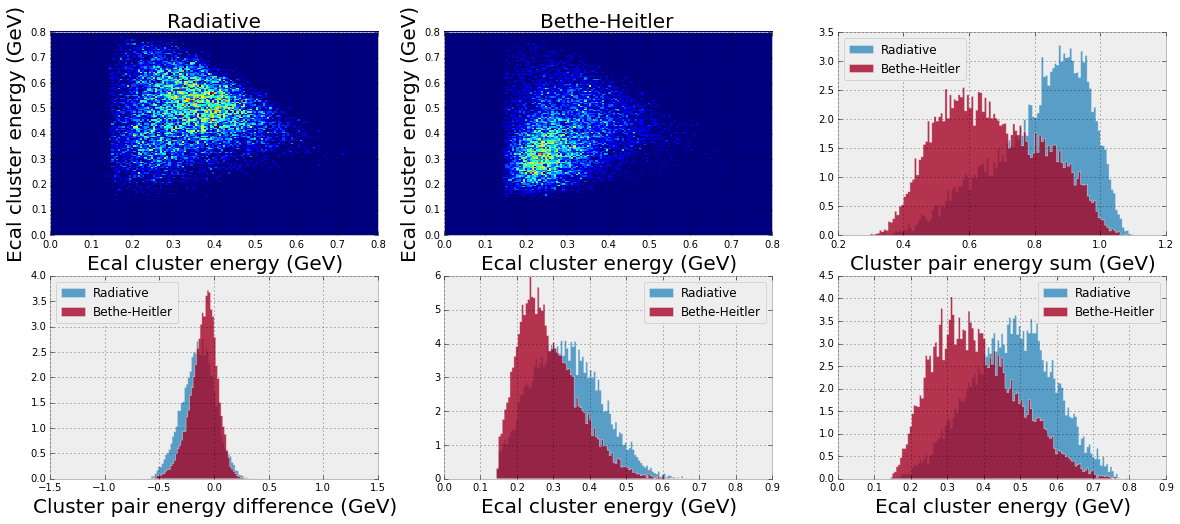

In [31]:
rad_cluster_0_energy = X_rad[:,0]
rad_cluster_1_energy = X_rad[:,1]
bh_cluster_0_energy = X_bh[:,0]
bh_cluster_1_energy = X_bh[:,1]

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(20,8))

bkg_names = ['Radiative', 'Bethe-Heitler']

ax0.hist2d(rad_cluster_0_energy, rad_cluster_1_energy, bins=150, range=[[0, 0.8], [0, 0.8]]);
ax0.set_xlabel("Ecal cluster energy (GeV)", fontsize=20)
ax0.set_ylabel("Ecal cluster energy (GeV)", fontsize=20)
ax0.set_title(bkg_names[0], fontsize=20)

ax1.hist2d(bh_cluster_0_energy, bh_cluster_1_energy, bins=150, range=[[0, 0.8], [0, 0.8]]);
ax1.set_xlabel("Ecal cluster energy (GeV)", fontsize=20)
ax1.set_ylabel("Ecal cluster energy (GeV)", fontsize=20)
ax1.set_title(bkg_names[1], fontsize=20)

ax2.hist(rad_cluster_0_energy+rad_cluster_1_energy, bins=150, range=(0.2, 1.2), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[0]);
ax2.hist(bh_cluster_0_energy+bh_cluster_1_energy, bins=150, range=(0.2, 1.2), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[1]);
ax2.set_xlabel("Cluster pair energy sum (GeV)", fontsize=20)
ax2.legend(loc=2)

ax3.hist(rad_cluster_0_energy-rad_cluster_1_energy, bins=150, range=(-1.2, 1.2), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[0]);
ax3.hist(bh_cluster_0_energy-bh_cluster_1_energy, bins=150, range=(-1.2, 1.2), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[1]);
ax3.set_xlabel("Cluster pair energy difference (GeV)", fontsize=20)
ax3.legend(loc=2)

ax4.hist(rad_cluster_0_energy, bins=150, range=(0, 0.8), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[0])
ax4.hist(bh_cluster_0_energy, bins=150, range=(0, 0.8), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[1])
ax4.set_xlabel("Ecal cluster energy (GeV)", fontsize=20)
ax4.legend()

ax5.hist(rad_cluster_1_energy, bins=150, range=(0, 0.8), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[0] )
ax5.hist(bh_cluster_1_energy, bins=150, range=(0, 0.8), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[1])
ax5.set_xlabel("Ecal cluster energy (GeV)", fontsize=20)
ax5.legend();

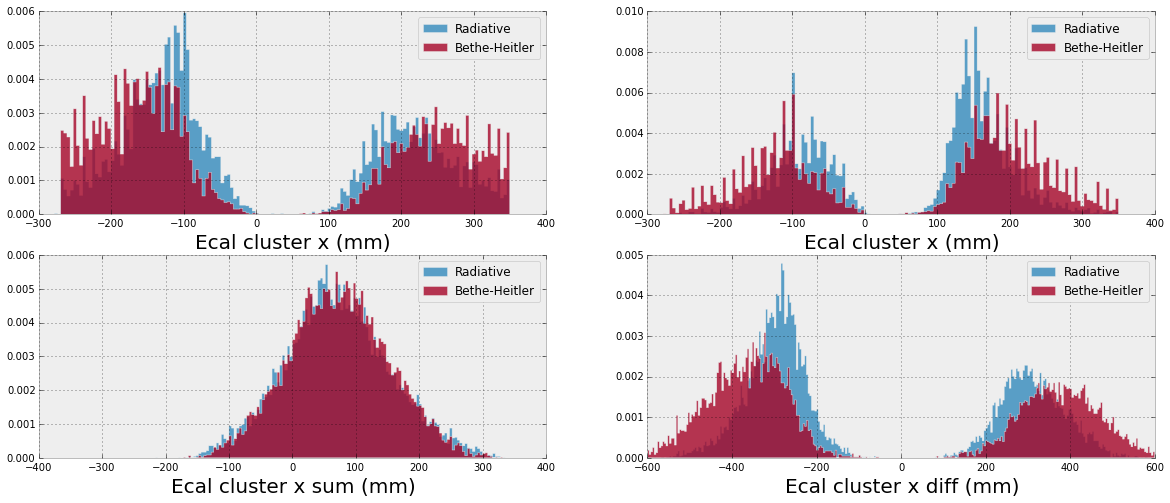

In [32]:
rad_cluster_0_x = X_rad[:,2]
rad_cluster_1_x = X_rad[:,3]
bh_cluster_0_x = X_bh[:,2]
bh_cluster_1_x = X_bh[:,3]

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 8))

ax0.hist(rad_cluster_0_x, bins=150, range=(-300, 350), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[0])
ax0.hist(bh_cluster_0_x, bins=150, range=(-300, 350), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[1])
ax0.set_xlabel("Ecal cluster x (mm)", fontsize=20)
ax0.legend()

ax1.hist(rad_cluster_1_x, bins=150, range=(-300, 350), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[0])
ax1.hist(bh_cluster_1_x, bins=150, range=(-300, 350), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[1])
ax1.set_xlabel("Ecal cluster x (mm)", fontsize=20)
ax1.legend()

ax2.hist(rad_cluster_0_x + rad_cluster_1_x, bins=200, range=(-400, 400), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[0])
ax2.hist(bh_cluster_0_x + bh_cluster_1_x, bins=200, range=(-400, 400), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[1]);
ax2.set_xlabel("Ecal cluster x sum (mm)", fontsize=20)
ax2.legend()

ax3.hist(rad_cluster_0_x - rad_cluster_1_x, bins=300, range=(-600, 600), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[0])
ax3.hist(bh_cluster_0_x - bh_cluster_1_x, bins=300, range=(-600, 600), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[1])
ax3.set_xlabel("Ecal cluster x diff (mm)", fontsize=20);
ax3.legend()


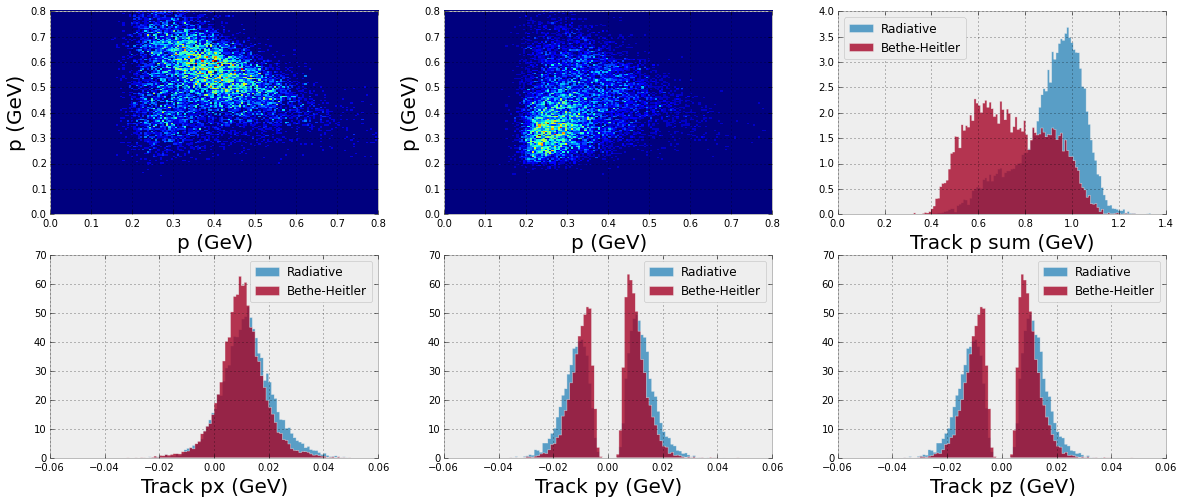

In [42]:
rad_track_0_p = X_rad[:,6]
rad_track_0_px = X_rad[:,7]
rad_track_0_py = X_rad[:,8]
rad_track_0_pz = X_rad[:,9]
rad_track_1_p = X_rad[:,15]
rad_track_1_px = X_rad[:,16]
rad_track_1_py = X_rad[:,17]
rad_track_1_pz = X_rad[:,18]

bh_track_0_p = X_bh[:,6]
bh_track_0_px = X_bh[:,7]
bh_track_0_py = X_bh[:,8]
bh_track_0_pz = X_bh[:,9]
bh_track_1_p = X_bh[:,15]
bh_track_1_px = X_bh[:,16]
bh_track_1_py = X_bh[:,17]
bh_track_1_pz = X_bh[:,18]

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(20,8))

ax0.hist2d(rad_track_0_p, rad_track_1_p, bins=150, range=[[0, 0.8], [0, 0.8]])
ax0.set_xlabel("p (GeV)", fontsize=20)
ax0.set_ylabel("p (GeV)", fontsize=20)

ax1.hist2d(bh_track_0_p, bh_track_1_p, bins=150, range=[[0, 0.8], [0, 0.8]])
ax1.set_xlabel("p (GeV)", fontsize=20)
ax1.set_ylabel("p (GeV)", fontsize=20)

ax2.hist(rad_track_0_p + rad_track_1_p, bins=150, range=(0.02, 1.4), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[0])
ax2.hist(bh_track_0_p + bh_track_1_p, bins=150, range=(0.02, 1.4), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[1])
ax2.set_xlabel("Track p sum (GeV)", fontsize=20)
ax2.legend(loc=2)

ax3.hist(rad_track_0_px, bins=100, range=(-0.05, 0.05), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[0]);
ax3.hist(bh_track_0_px, bins=100, range=(-0.05, 0.05), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[1]);
ax3.set_xlabel("Track px (GeV)", fontsize=20)
ax3.legend()

ax4.hist(rad_track_0_py, bins=100, range=(-0.05, 0.05), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[0]);
ax4.hist(bh_track_0_py, bins=100, range=(-0.05, 0.05), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[1]);
ax4.set_xlabel("Track py (GeV)", fontsize=20)
ax4.legend()

ax5.hist(rad_track_0_py, bins=100, range=(-0.05, 0.05), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[0]);
ax5.hist(bh_track_0_py, bins=100, range=(-0.05, 0.05), alpha=0.8, normed=True, histtype="stepfilled", label=bkg_names[1]);
ax5.set_xlabel("Track pz (GeV)", fontsize=20)
ax5.legend();


From the distributions of some of the features, the differences between Bethe-Heitler and Radiatives is already visible.  Specifically, the sum of the track momentum already seemed to have the most discriminating power.  Next we take the data ntuples from the signal and background, merge and shuffle them and then prepare them to be used to train the classifier.

In [34]:
# Create the targets
y_rad = np.ones(len(X_rad))
y_bh = np.zeros(len(X_bh))

rad_zip = zip(X_rad, y_rad)
bh_zip = zip(X_bh, y_bh)

X_merge = np.concatenate((rad_zip, bh_zip))
np.random.shuffle(X_merge)

X_list, y_list = map(list, zip(*X_merge))

X = np.array(X_list)
print "Shape of X: " + str(X.shape)

y = np.array(y_list)
print "Shape of y: " + str(y.shape)

Shape of X: (23900, 25)
Shape of y: (23900,)


## Using Ensemble Methods to Classify Radiatives

### Evaluation of Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
from collections import OrderedDict

RANDOM_STATE = 123

forest_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in forest_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 200

for label, clf in forest_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

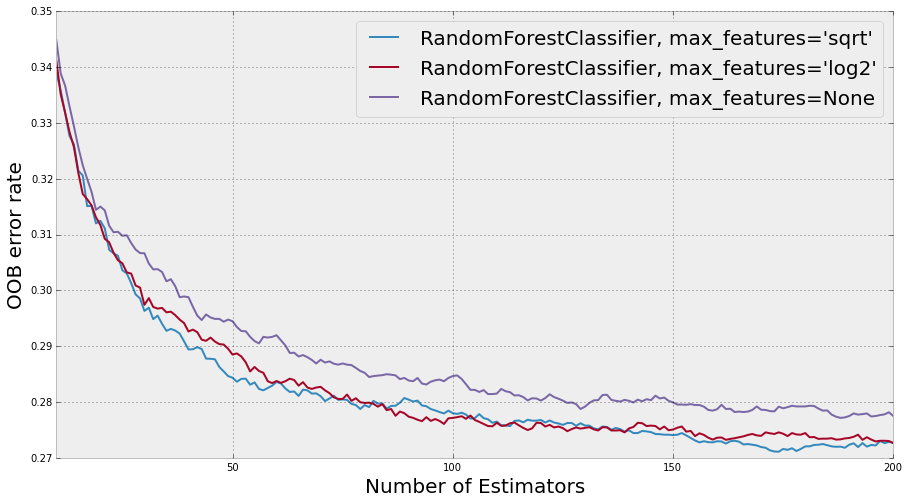

In [37]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    ax.plot(xs, ys, label=label)

ax.set_xlim(min_estimators, max_estimators)
ax.set_xlabel("Number of Estimators", fontsize=20)
ax.set_ylabel("OOB error rate", fontsize=20)
ax.legend(loc=1, fontsize=20);

In [43]:
# Open a ROOT file and create a record array out of both the preprocessed BH and Rad ntuples
X_rad_test_rec = rnp.root2array("rad_preprocessed_file_test.root")
X_bh_test_rec = rnp.root2array("bh_preprocessed_file_test.root")

features_test = rnp.list_branches("rad_preprocessed_file_test.root")

# Convert the data into an array that can be used as an input into scikit-learn
X_rad_test = rnp.rec2array(X_rad_test_rec)
X_bh_test = rnp.rec2array(X_bh_test_rec)

# Truncate the array containing the Radiative features such that it's correctly weighted 
# for the expected cross sections
X_rad_test = X_rad[:len(X_bh_test)/4]

# Create the targets
y_rad_test = np.ones(len(X_rad_test))
y_bh_test = np.zeros(len(X_bh_test))

rad_test_zip = zip(X_rad_test, y_rad_test)
bh_test_zip = zip(X_bh_test, y_bh_test)

X_test_merge = np.concatenate((rad_test_zip, bh_test_zip))
np.random.shuffle(X_test_merge)

X_test_list, y_test_list = map(list, zip(*X_test_merge))

X_test = np.array(X_test_list)
print "Shape of X: " + str(X_test.shape)

y_test = np.array(y_test_list)
print "Shape of y: " + str(y_test.shape)

Shape of X: (28785, 25)
Shape of y: (28785,)


In [44]:
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 123

#
forest_clf = RandomForestClassifier(max_features='sqrt', n_jobs=-1, n_estimators=160, random_state=RANDOM_STATE)
forest_clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

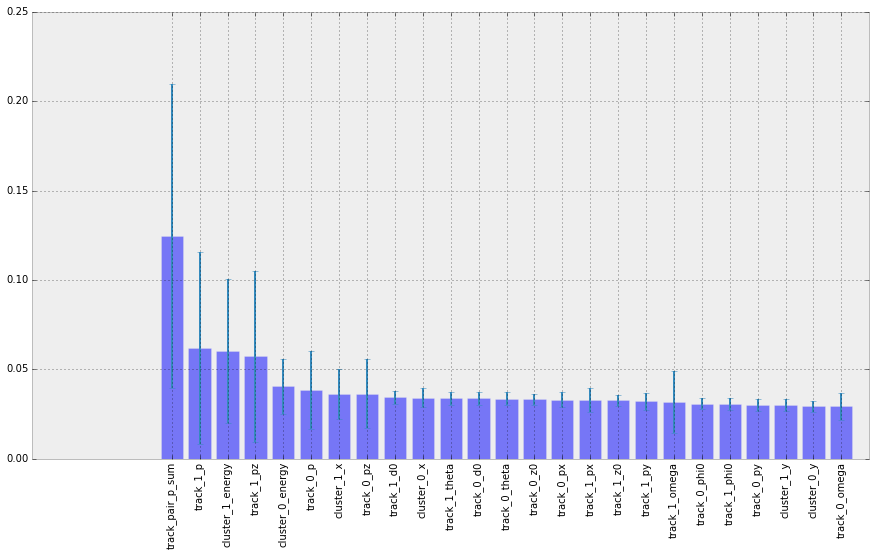

In [45]:
importances = forest_clf.feature_importances_
std = np.std([clf.feature_importances_ for clf in forest_clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
fig, ax0 = plt.subplots(figsize=(15, 8))
sorted_features = []
[sorted_features.append(features_test[index]) for index in indices]
ax0.bar(range(len(importances)), importances[indices], yerr=std[indices], align="center", alpha=0.5)
plt.xticks(range(len(importances)), sorted_features, rotation='vertical');

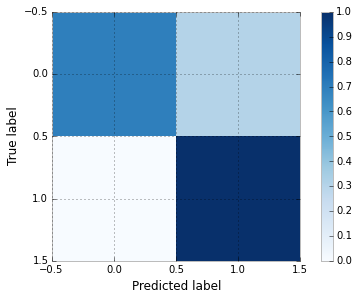

In [53]:
y_predictions = forest_clf.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmap=plt.cm.Blues
plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
plt.colorbar()
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label');

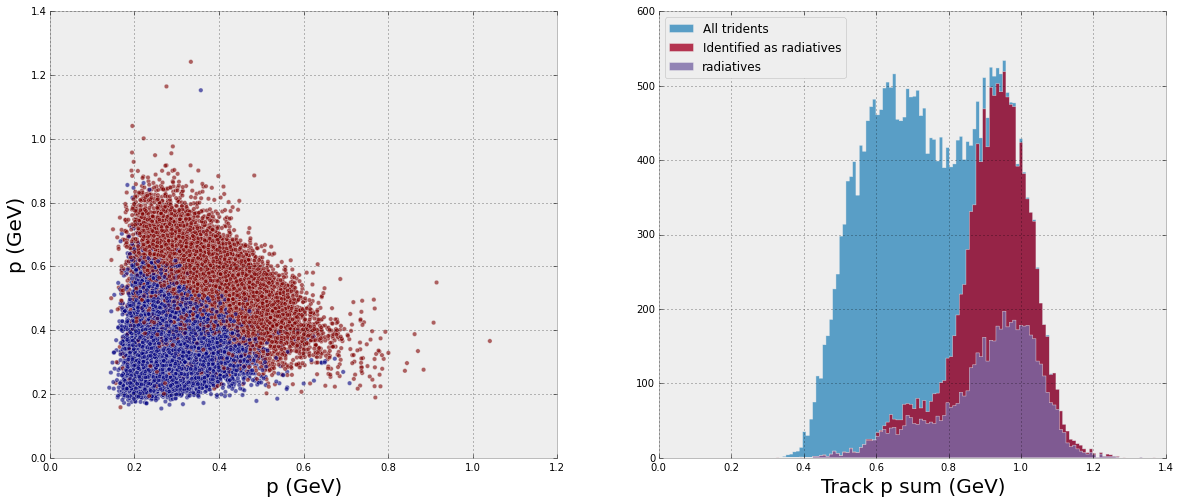

In [57]:
rad_track_0_p = X_rad_test[:,6]
rad_track_0_px = X_rad_test[:,7]
rad_track_0_py = X_rad_test[:,8]
rad_track_0_pz = X_rad_test[:,9]
rad_track_1_p = X_rad_test[:,15]
rad_track_1_px = X_rad_test[:,16]
rad_track_1_py = X_rad_test[:,17]
rad_track_1_pz = X_rad_test[:,18]

bh_track_0_p = X_bh_test[:,6]
bh_track_0_px = X_bh_test[:,7]
bh_track_0_py = X_bh_test[:,8]
bh_track_0_pz = X_bh_test[:,9]
bh_track_1_p = X_bh_test[:,15]
bh_track_1_px = X_bh_test[:,16]
bh_track_1_py = X_bh_test[:,17]
bh_track_1_pz = X_bh_test[:,18]

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20,8))

ax0.scatter(X_test[:,6], X_test[:,15], c=y_predictions, alpha=0.6)
ax0.set_xlabel("p (GeV)", fontsize=20)
ax0.set_ylabel("p (GeV)", fontsize=20)

ax1.hist(X_test[:, 24], bins=150, range=(0.02, 1.4), alpha=0.8, histtype="stepfilled", label="All tridents")
ax1.hist(X_test[:, 24][y_predictions == 1], bins=150, range=(0.02, 1.4), alpha=0.8, histtype="stepfilled", label="Identified as radiatives")
ax1.hist(X_test[:, 24][y_test == 1], bins=150, range=(0.02, 1.4), alpha=0.8, histtype="stepfilled", label="radiatives")
ax1.legend(loc=2)

ax1.set_xlabel("Track p sum (GeV)", fontsize=20);


In [67]:
print "Percentage of radiatives to Bethe-Heitler in final event sample: " + str(float(len(X_test[:,24][y_test == 1]))/float(len(X_test[:,24][y_predictions == 1]))

Percentage of radiatives to Bethe-Heitler in final event sample: 
0.447562776957
